# Count Triangles in complex Graphs

>[Count Triangles in complex Graphs](#scrollTo=YtLP4Cx8glT2)

>>[1.Import the graph](#scrollTo=Fo7kV7lPgDHA)

>>[2.Visualization, pre-processing and basic theory](#scrollTo=RIuNTuZbg7Ne)

>>>>[2.1 Remove self-loops if any.](#scrollTo=OzBePmegwRYv)

>>>[2.2 Visualize the Graph.](#scrollTo=Konpx66ewE_T)

>>>[2.3 Basic theory.](#scrollTo=c5lFCYkLwKl1)

>>>>[2.3.1 Brute-force (All triplets)](#scrollTo=DMbFI3S37Tyj)

>>>>[2.3.2 Node-Iterator](#scrollTo=X2KFUi887RIM)

>>>>[2.3.3 Compact Forward](#scrollTo=HN3etdfH8_z5)

>>>[2.4 Performance comparison of the exact techiques.](#scrollTo=wyCVVHsdmVz_)

>>[3.Implementation of the DOULION method.](#scrollTo=JxPS4GcXJOco)

>[4.Implementation of Streaming Algorithm](#scrollTo=7qzcP3NbTqUc)





---



## 1.Import the graph
For testing and implementation purposes we are using an undirected graph. The graph is available on [SNAP](https://snap.stanford.edu/data/ca-GrQc.html).

**Dataset statistics**
- Nodes	5242
- Edges	14496
- Nodes in largest WCC	4158 (0.793)
- Edges in largest WCC	13428 (0.926)
- Nodes in largest SCC	4158 (0.793)
- Edges in largest SCC	13428 (0.926)
- Average clustering coefficient	0.5296
- **Number of triangles	48260**
- Fraction of closed triangles	0.3619
- Diameter (longest shortest path)	17
- 90-percentile effective diameter	7.6


In [ ]:
import networkx as nx
import io
import numpy as np
import pandas as pd
import itertools
from scipy.sparse import csr_matrix
import matplotlib.pyplot as plt
import time
%matplotlib inline
import matplotlib.pyplot as plt
!pip install 'scipy>=1.8'
#! pip install 'networkx==2.6'

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
#Here, we use a small-sized dataset (14496 edges). We need two more datasets for sufficient comparison of Doulion:
#medium-sized dataset (93497 edges) retrieved from http://snap.stanford.edu/: http://snap.stanford.edu/data/ca-CondMat.html 
#large-sized dataset (2766607 edges) retrieved from http://snap.stanford.edu/: http://snap.stanford.edu/data/roadNet-CA.html

from google.colab import files
uploaded = files.upload()

Saving roadNet-PA.txt to roadNet-PA.txt


In [ ]:
#g = nx.read_edgelist(io.BytesIO(uploaded["CA-GrQc.txt"]),create_using=nx.Graph(), nodetype = int)
#g = nx.read_edgelist(io.BytesIO(uploaded["ca-CondMat.txt"]),create_using=nx.Graph(), nodetype = int)
g = nx.read_edgelist(io.BytesIO(uploaded["roadNet-CA.txt"]),create_using=nx.Graph(), nodetype = int)


In [ ]:
triangles_nx = sum(nx.triangles(g).values()) / 3
print(triangles_nx)

67150.0


## 2.Visualization, pre-processing and basic theory

#### 2.1 Remove self-loops if any.

In [ ]:
g.remove_edges_from(nx.selfloop_edges(g))


### 2.2 Visualize the Graph.



 Graphical Representation of G: 




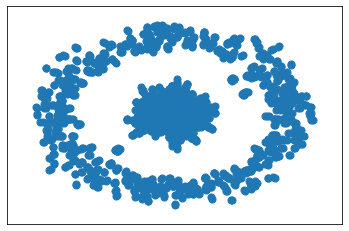

In [ ]:
print('\n\n Graphical Representation of G: \n\n')
nx.draw_networkx(g,with_labels=False, node_size=50)

### 2.3 Basic theory.

We list the following formulas from graph theory.

The **indegree\outdegree** of node **i** is defined as $$K^{in}_i=K^{out}_i=\sum\limits_{j=1}^{N}{A_{ij}}$$

The **number of triangles** in a graph is defined as $$T(A)=\frac{tr(A^3)}{6}$$

The **number of triangles** *incident to node* **i** is defined as $$T_i\left(A\right)=\frac{1}{2}\sum\limits_{j=1}^{N}\sum\limits_{k=1}^{N}{A_{ij}A_{jk}A_{ki}\left(1-\delta_{j,k}\right)}:\delta_{j,k} =\left\{\begin{array}{ll}0  & \mbox{if } j \neq k \\1 & \mbox{if } j = k\end{array}\right.$$


#### 2.3.1 Brute-force (All triplets)
The application of the above formula without any optimization techique will be our baseline brute-force model. The triangle counting brute-force algorithm examines all triplets of nodes u,v,w. If all of the edges appear, a triangle has been detected.

In [ ]:
def all_triplets(g):
  '''computes all triangles of the network by checking all triplets'''

  A = nx.adjacency_matrix(g).todense()
  adj_matrix_l3 = np.array(A**3)
  triangles = int(np.sum([adj_matrix_l3[i][i] for i in range(0,g.number_of_nodes())]) * 1/6)

  return triangles



In [ ]:
AllTriplTriangles = all_triplets(g)
print("The number of triangles that brute force algorithm has found are",AllTriplTriangles)

Total run time: 1h 12mins

#### 2.3.2 Node-Iterator
Another method is to examine each node of G to see if it forms any triangles with its neighbors. This algorithm loops through all of the graph's nodes (NodeIterator). Let v be the next node to be checked. Check if all possible pairs of nodes u, w (both neighbors of v) are connected by an edge. If the answer is YES, output the triangle v, u, w.

In [ ]:
def node_iterator(g):
  '''runs NodeIterator algorithm &  returns the total number of triangles in the network''' 
  
  start_time_ni = time.process_time()
  nodes = nx.nodes(g)
  triangs=0
  for node in nodes: #for all nodes
    bors = list(nx.neighbors(g,node)) #the neighbors of each node
    if len(bors)>1:
      for pair in itertools.combinations(bors,r=2): #for all combinations of 2 of node's neighbors
        if pair[0] in list(nx.neighbors(g,pair[1])): #if they are also neighbors
          triangs=triangs+1

  time_of_ni = (time.process_time() - start_time_ni)
  return int(triangs/3), time_of_ni



In [ ]:
NodeIterTriangles, time_ni = node_iterator(g)
print("The number of triangles that NodeIterator has found are",NodeIterTriangles)
print("time needed for NodeIterator to run", time_ni)

The number of triangles that NodeIterator has found are 67150
time needed for NodeIterator to run 4.417737073999888


#### 2.3.3 Compact Forward
Algorithm CompactForward (it does not require additional space to store the neighbors of every node dynamically).

In [ ]:
def c_forward(graph):
    '''runs Compact Forward algorithm &  returns the total number of triangles in the network''' 
    
    time_start_cf = time.process_time()   
    tri = 0 
    vertices = graph.nodes()
    degrees = [graph.degree(v) for v in vertices]
    #sort nodes based on decreasing order o degree
    newDeg, newVer = zip(*sorted(zip(degrees,vertices), reverse=True))
    newDeg, newVer =np.array(newDeg), np.array(newVer)
    ver_dict = dict(zip(newVer, range(len(newVer)))) #dict node_id:index
    i = 0
    for v in newVer:
        
        neighbors = list(graph.neighbors(v))
        if len(neighbors)>0:
            #sort also neighbors on decreasing order of degree
            nei_degrees = [graph.degree(v) for v in neighbors]
            newNeiDeg, newNeiVer = zip(*sorted(zip(nei_degrees,neighbors), reverse=True))
            idx_base  = i
            #if the smallest degree is higher than v's degree, ignore
            idx_check = ver_dict[newNeiVer[-1]]
            if idx_check>idx_base:
                neib = filter(lambda item: ver_dict[item] > idx_base, newNeiVer)

                for u in neib: #keep only neighbors with lower degree                           
                    u_neighbors = list(graph.neighbors(u))
                    u_nei_degrees = [graph.degree(i) for i in u_neighbors]
                    _, newNei_u = zip(*sorted(zip(u_nei_degrees,u_neighbors), reverse=True))
                    u1 = newNei_u[0]  #first  neighbor of u
                    v1 = newNeiVer[0] #first neighbor of v
                    c_u = 0 #counter for neighbors of u
                    c_v = 0 #counter for neighbors of v
                    idx_candid1 = ver_dict[u1]
                    idx_candid2 = ver_dict[v1]                
                   
                    while (c_v<len(newNeiVer)-1) or (c_u<len(newNei_u)-1):
                        if (idx_candid1<idx_base) & (idx_candid2<idx_base):
                            if idx_candid1<idx_candid2:                            
                                if c_u < len(newNei_u)-1:
                                    c_u += 1
                                    u1 = newNei_u[c_u]  #next neighbor of u
                                    idx_candid1 = ver_dict[u1]
                                else:
                                    break                                    
                            elif idx_candid1>idx_candid2:                            
                                if c_v < len(newNeiVer)-1:
                                    c_v += 1
                                    v1 = newNeiVer[c_v]
                                    idx_candid2 = ver_dict[v1]
                                else:
                                    break                                    
                            else:
                                tri += 1                            
                                if c_u < len(newNei_u)-1:
                                    c_u += 1
                                    u1 = newNei_u[c_u]
                                    idx_candid1 = ver_dict[u1]                        
                                if c_v < len(newNeiVer)-1:
                                    c_v += 1
                                    v1 = newNeiVer[c_v]
                                    idx_candid2 = ver_dict[v1]
                        else:
                            break
        i+=1
    time_of_cf = (time.process_time() - time_start_cf)         
    return tri, time_of_cf

In [ ]:
cForwardTriangles, time_cf = c_forward(g)
print("The number of triangles that Compact Forward has found are",cForwardTriangles)
print("time needed for Compact Forward to run", time_cf)

The number of triangles that Compact Forward has found are 67150
time needed for Compact Forward to run 27.678170604000115


### 2.4 Performance comparison of the exact techiques.
As all the above techiques are exact, there is no need to compare the results of each implementation rather than their performance. In the table bellow we can see each one of the three alfgorithms alongside with their performaces to three different graphs.

- Graph 1:
- Graph 2:
- Graph 3:

| Algorithm       | Graph1 | Graph2 | Graph3 |
| --------------- | ------ | ------ | ------ |
| All Triplets    | `1.0`  | `1.0`  | `1.0`  |
| Node Iterator   | `1.0`  | `1.0`  | `1.0`  |
| Compact Forward | `1.0`  | `1.0`  | `1.0`  |

### 3.Implementation of the DOULION method.


In [ ]:
#sparsification of graph
def sparsify_graph(g, p):
    '''it sparsifies the graph according to the value of p'''

    g_sparse = nx.Graph()
    for u,v in g.edges():
        if np.random.random() <= p:
            g_sparse.add_edge(u,v)
    return g_sparse

In [ ]:
def doulion(g, time_cf, time_ni):
  '''it runs Doulion algorithm combined with NodeIterator and Compact Forward and 
  returns lists of related error, accuracy and speedups'''

  rel_err_avg, acc_avg, dcf_speedup, dni_speedup, speedup_ni,\
    speedup_cf = [], [], [], [], [], []

  for p in [0.1, 0.3, 0.5,0.7,0.9]:
      acc_cf, rel_err_cf, acc_NIt, rel_err_NIt = [], [], [], []
      for i in range(10): #run for 10 times
          print(i)
          time_start = time.process_time()  
          graph = sparsify_graph(g, p)  #sparsify graph        
          time_doul = (time.process_time() - time_start)
          time_start_dcf = time.process_time()         
          tri_cf,_ = c_forward(graph) #run compact forward
          tri_cf_final = tri_cf/p**3
          time_dcf = (time.process_time() - time_start_dcf + time_doul)
          time_dcf = (time.process_time() - time_start_dcf)
          speedup_cf.append(time_cf/time_dcf) #compute speedup for CF
          if tri_cf_final <= triangles_nx: #compute accuracy 
            acc_cf.append(tri_cf_final/triangles_nx)
          else:
            num = triangles_nx-(tri_cf_final-triangles_nx)
            acc_cf.append(num/triangles_nx)
          rel_err_CF = abs((tri_cf_final-triangles_nx)/triangles_nx)
          rel_err_cf.append(rel_err_CF)
          time_start_dni = time.process_time()
          tri_NIt,_ = node_iterator(graph) #run NodeIterator
          tri_NIt_final = tri_NIt/p**3
          time_dni = (time.process_time() - time_start_dni  + time_doul)
          time_dni = (time.process_time() - time_start_dni)
          speedup_ni.append(time_ni/time_dni) #compute speedup for NI
          if tri_NIt_final <= triangles_nx: #compute accuracy to check if the values are the same
            acc_NIt.append(tri_NIt_final/triangles_nx)
          else:
            num = triangles_nx-(tri_NIt_final-triangles_nx)
            acc_NIt.append(num/triangles_nx)
          rel_err_nit = abs((tri_NIt_final-triangles_nx)/triangles_nx)
          rel_err_NIt.append(rel_err_nit)
      rel_err_avg.append(np.mean(rel_err_cf))
      acc_avg.append(np.mean(acc_cf))
      dcf_speedup.append(np.mean(speedup_cf))
      dni_speedup.append(np.mean(speedup_ni))
      print('for CF & p=',p, 'mean related error is: ', np.mean(rel_err_cf), 'accuracy is ', np.mean(acc_cf))
      print('for NI & p=',p,'mean related error is: ', np.mean(rel_err_NIt), 'accuracy is ', np.mean(acc_NIt))
      print('for p=',p, 'std of related error is: ', np.std(rel_err_NIt),'std of accuracy is ', np.std(acc_NIt))
  return rel_err_avg, acc_avg, dcf_speedup, dni_speedup



In [ ]:
rel_err, acc, dcf_speedup, dni_speedup = doulion(g, time_cf, time_ni)
print(dcf_speedup, dni_speedup)

0
1
2
3
4
5
6
7
8
9
for CF & p= 0.1 mean related error is:  0.08294862248696942 accuracy is  0.9170513775130307
for NI & p= 0.1 mean related error is:  0.08294862248696942 accuracy is  0.9170513775130307
for p= 0.1 std of related error is:  0.05196786024468136 std of accuracy is  0.0519678602446814
0
1
2
3
4
5
6
7
8
9
for CF & p= 0.3 mean related error is:  0.027406855850638446 accuracy is  0.9725931441493616
for NI & p= 0.3 mean related error is:  0.027406855850638446 accuracy is  0.9725931441493616
for p= 0.3 std of related error is:  0.017253559723637367 std of accuracy is  0.017253559723637357
0
1
2
3
4
5
6
7
8
9
for CF & p= 0.5 mean related error is:  0.005748324646314222 accuracy is  0.9942516753536857
for NI & p= 0.5 mean related error is:  0.005748324646314222 accuracy is  0.9942516753536857
for p= 0.5 std of related error is:  0.004232440420861626 std of accuracy is  0.004232440420861637
0
1
2
3
4
5
6
7
8
9
for CF & p= 0.7 mean related error is:  0.0038727968583454593 accuracy

In [ ]:
def createplot(error,speedup, alg):
  '''creates scatter plot accuracy-speedup'''

  plt.scatter(error,speedup)
  plt.scatter
  plt.xlabel('Accuracy', fontsize=16)
  plt.ylabel("Speedup", fontsize=16)
  plt.title(alg, fontsize=18)
  plt.xticks(fontsize=14)
  plt.yticks(fontsize=14)
  plt.savefig(alg+"_GRQC.png", bbox_inches='tight',dpi=300)
  #plt.savefig(alg+"_roadCA.png", bbox_inches='tight',dpi=300)
  #plt.savefig(alg+"_CondMat.png", bbox_inches='tight',dpi=300)
  plt.show()

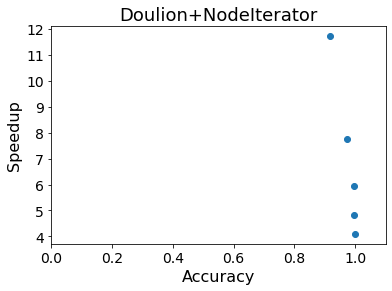

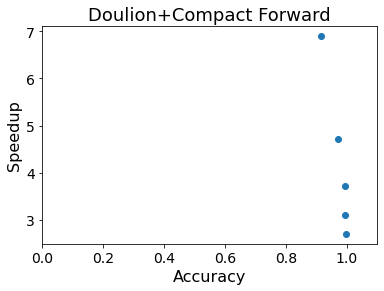

In [ ]:
createplot(acc, dni_speedup, 'Doulion+NodeIterator') #plot speedup for NodeIterator
createplot(acc, dcf_speedup, 'Doulion+Compact Forward') #plot speedup for Compact Forward

#### 3.1 Brute Force on sparcified

# 4.Implementation of Streaming Algorithm
The Triest algorithm is a streaming algorithm that estimates the number of triangles in a graph. It was introduced by Alessandro Epasto, Sofya Raskhodnikova, and Aaron Bernstein in the paper "Counting Triangles in Large Graphs with a Single Pass and Linear Memory" (2016).

The algorithm works by maintaining estimates of the number of triangles in the graph as it processes a stream of edges. It does this by keeping track of two estimates: the global estimate, which is the total number of triangles in the graph, and the local estimate, which is the number of triangles that include a particular vertex.

The algorithm starts by initializing the global and local estimates to zero. Then, as each edge is processed, it updates the estimates by incrementing the global estimate and adding one to the local estimates of the two vertices connected by the edge.

Finally, after all the edges have been processed, the algorithm calculates the final estimates by dividing the global and local estimates by the total number of edges processed.

The Triest algorithm has the advantage of being very fast and requiring only a single pass over the data, making it well-suited for large graphs where it is not practical to compute the exact number of triangles. It also has good accuracy, with error rates typically less than 10%.

In [ ]:
def triest(G, samples):
    M = 0
    global_estimates = {}
    local_estimates = {}

    # Initialize the local and global estimates
    for u, v in samples:
        if u not in local_estimates:
            local_estimates[u] = {}
        if v not in local_estimates:
            local_estimates[v] = {}
        if u not in global_estimates:
            global_estimates[u] = 0
        if v not in global_estimates:
            global_estimates[v] = 0

        local_estimates[u][v] = 0
        local_estimates[v][u] = 0
        global_estimates[u] += 1
        global_estimates[v] += 1
        M += 1

    # Iterate through the samples and update the estimates
    for u, v in samples:
        M += 1
        for w in G[u]:
            if w in local_estimates[v]:
                local_estimates[v][w] += 1
                local_estimates[w][v] += 1
            if w in global_estimates:
                global_estimates[w] += 1
        for w in G[v]:
            if w in local_estimates[u]:
                local_estimates[u][w] += 1
                local_estimates[w][u] += 1
            if w in global_estimates:
                global_estimates[w] += 1

    # Calculate the final estimates
    for u, v in samples:
        if u in global_estimates and v in global_estimates:
            global_estimates[u] = (M * global_estimates[u]) / (global_estimates[u] + global_estimates[v])
            global_estimates[v] = (M * global_estimates[v]) / (global_estimates[u] + global_estimates[v])
        if u in local_estimates[v] and v in local_estimates[u]:
            local_estimates[u][v] = (M * local_estimates[u][v]) / (local_estimates[u][v] + local_estimates[v][u])
            local_estimates[v][u] = (M * local_estimates[v][u]) / (local_estimates[u][v] + local_estimates[v][u])

    return global_estimates, local_estimates


In [ ]:
## FOR TESTING
triest_triangles = triest(g,)
print(triest_triangles)

TypeError: ignored

In [ ]:
def update_counters(G,u,v):

  neighbors = list(sorted(nx.common_neighbors(G, u, v)))



def triest1(G):

  G = nx.read_edgelist(io.BytesIO(uploaded["CA-GrQc.txt"]),create_using=nx.Graph(), nodetype = int)

  S = 0
  t = 0
  counter = 0

  for u,v in G.edges:
    t += 1
    update_counters(G,u,v)


triest1(g)


In [ ]:
from google.colab import files
uploaded = files.upload()

Saving CA-GrQc.txt to CA-GrQc.txt


In [ ]:
# Helper Funtions - Triest
def flip_biased_coin(M,_t):
  head_prob = random.random()
  if head_prob <= M/t:
      return True
  else:
      return False

def sample_edge (sample,u,v,M,_t):
  if _t<=M:
    return True
  elif flip_biased_coin(M,_t):
    # random edge choice
    chosen_edge = random.choice(list(sample.edges))
    sample.remove_edge(chosen_edge[0],chosen_edge[1])
    return True
  return False

def update_counters(sample,u,v,M,_t,globalT):
  if (u in sample.nodes) & (v in sample.nodes):
    common_neighbors = list(sorted(nx.common_neighbors(sample, u, v)))
    if not common_neighbors:
      return globalT
    increment_t = max(1, int(((_t-1)*(_t-2))/(M * (M - 1))))
    for neighbor in common_neighbors:
      globalT += increment_t
  return globalT # globalT = update_counters(sample, u,v,M,_t,globalT)


In [ ]:
import pandas as pd
from networkx.algorithms.distance_regular import global_parameters
import random

df = pd.read_csv('Book1.csv', delimiter=';')
print(len(df))

df = df.drop_duplicates()
df = df.apply(lambda r: sorted(r), axis = 1).drop_duplicates()
print(len(df))

28979
14496


In [ ]:
edge_list = list(df.values)
print(type(edge_list))

<class 'list'>


In [ ]:
#final TRIEST

M=14496 # Memory
globalT =0
t=0
#pace=10

sample =nx.empty_graph()

for edge in edge_list: 
  
  u = edge[0]
  v = edge[1]
  if u!=v: #check for the self-loops
    check = sample.has_edge(u,v) 
    if check==False:
      t+=1
      globalT = update_counters(sample,u,v,M,t,globalT)
      if sample_edge(sample,u,v,M,t):
        sample.add_edge(u,v)
      if t%10000==0:
        print(t,globalT)
'''
for i in range(0,len(edge_list), pace):
  if (i+pace)<=len(edge_list):
      edges = edge_list[i:i+pace]
  else:
      edges = edge_list[i:len(edge_list)]
  for edge in edges:       
    u = edge[0]
    v = edge[1]
    if u!=v: #check for the self-loops
      check = sample.has_edge(u,v) 
      if check==False:
        t+=1
        globalT = update_counters(sample,u,v,M,t,globalT)
        if sample_edge(sample,u,v,M,t):
          sample.add_edge(u,v)
        if t%10000==0:
          print(t,globalT)
'''    
            
        
print(nx.info(sample))
print(globalT)


10000 22277
Graph with 5241 nodes and 14484 edges
48260


<ipython-input-67-e22aed0b8f50>:45: DeprecationWarning: info is deprecated and will be removed in version 3.0.

  print(nx.info(sample))


In [ ]:

M=7000 # Memory
globalT =0
localT={}
t=0
pace=10

sample =nx.empty_graph()
n=0
with open('CA-GrQc.txt','r') as f:
  lines = f.readlines()
  print(type(lines[0]))

# Add first M edges to the graph

for line in lines: #while G_new.number_of_edges() < M :
  
  new = line.replace('\t', ' ').replace('\n', '')
  u,v = new.split(' ')
  check = sample.has_edge(u,v)
  if check==False:
    t+=1
    globalT = update_counters(sample,u,v,M,t,globalT)
    if sample_edge(sample,u,v,M,t):
      sample.add_edge(u,v)
    if t%10000==0:
      print(t,globalT)
      
print(nx.info(sample))
print(globalT)

<class 'str'>


KeyboardInterrupt: ignored

In [ ]:
print(nx.info(sample))
print(globalT)

Graph with 4828 nodes and 2986 edges
209009


<ipython-input-11-0d6a5cd36814>:1: DeprecationWarning: info is deprecated and will be removed in version 3.0.

  print(nx.info(sample))
